### Importamos librerias

In [1]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, precision_score, recall_score, accuracy_score, f1_score
import xgboost as xgb

In [3]:
import joblib
import os.path
from google.colab import drive

# Montar Google Drive en Colab
drive.mount('/content/drive')

# Ruta del archivo de modelo
ruta_archivo = "/content/drive/MyDrive/TP1/CH3/modelos/"
# ruta_archivo = "/content/drive/MyDrive/Orga-de-Datos/TP1/CH3/modelos/"

Mounted at /content/drive


Función para imprimir todas las métricas de todos los modelos

In [4]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

### Normalización del dataset

Importamos dataset de entrenamiento

In [5]:
dataset = pd.read_csv("https://drive.google.com/uc?export=download&id=1N_PQUWOXO7PfNegr8fJOB_U5eeZIzGJn")
dataset.shape

(60993, 31)

Importamos dataset de test

In [6]:
# https://drive.google.com/file/d/1JWqglsFAU_e8acYK-1XOY5nH8iNgiLP4/view?usp=share_link

dataset_test = pd.read_csv("https://drive.google.com/uc?export=download&id=1JWqglsFAU_e8acYK-1XOY5nH8iNgiLP4")
dataset_test.shape

(26535, 32)

In [7]:
# Defino un dicc con los meses en camelcase
meses_dict = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
              'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# Reemplazar los valores en el dataframe
dataset['arrival_date_month'] = dataset['arrival_date_month'].replace(meses_dict)
dataset_test['arrival_date_month'] = dataset_test['arrival_date_month'].replace(meses_dict)

#validamos
print(dataset['arrival_date_month'].unique())
print(dataset_test['arrival_date_month'].unique())

[ 9 10 12  3 11  7  6  4  8  2  1  5]
[11  5  8 10  6  3  7  9  4  2 12  1]


In [8]:
dataset_test.isna().sum()

hotel                                 0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
babies                                0
meal                                  0
country                              95
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              3363
company                           25218
days_in_waiting_list                  0


In [9]:
dataset_test.children.fillna(dataset_test['children'].mean(), inplace=True)

dataset_test.country.fillna('unknown', inplace=True)

dataset_test.agent.fillna(0, inplace=True)

dataset_test.company.fillna(0, inplace=True)

dataset_test.loc[dataset_test['meal'] == 'Undefined', 'meal'] = 'No meal'

# orden de la catedra
dataset_test.drop(columns=['reservation_status', 'reservation_status_date'], inplace=True)

Nos quedamos solo con el top 10 de paises para no tener tantas columnas

In [10]:
# dataset_test.country.value_counts().sort_values(ascending=False).head(10).index.to_list()

available_countries = {'PRT', 'GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BRA', 'BEL', 'USA'}

dataset['country'] = np.where(dataset['country'].isin(available_countries), dataset['country'], 'otro')

dataset_test['country'] = np.where(dataset_test['country'].isin(available_countries), dataset_test['country'], 'otro')

Nos quedamos solo con el top 10 de assigned_room_type para no tener tantas columnas

In [11]:
availables_assigned_room_type = {'A', 'D', 'E', 'F', 'G', 'C', 'B', 'H', 'I', 'K'}

dataset['assigned_room_type'] = np.where(dataset['assigned_room_type'].isin(availables_assigned_room_type), dataset['assigned_room_type'], 'otro')

dataset_test['assigned_room_type'] = np.where(dataset_test['assigned_room_type'].isin(availables_assigned_room_type), dataset_test['assigned_room_type'], 'otro')

Nos quedamos solo con el top 8 de assigned_room_type para no tener tantas columnas

In [12]:
availables_reserved_room_type = {'A', 'D', 'E', 'F', 'G', 'C', 'B', 'H'}

dataset['reserved_room_type'] = np.where(dataset['reserved_room_type'].isin(availables_reserved_room_type), dataset['reserved_room_type'], 'otro')

dataset_test['reserved_room_type'] = np.where(dataset_test['reserved_room_type'].isin(availables_reserved_room_type), dataset_test['reserved_room_type'], 'otro')

In [13]:
print(dataset.distribution_channel.value_counts())
print(dataset_test.distribution_channel.unique())

TA/TO        51093
Direct        6678
Corporate     3132
GDS             89
Undefined        1
Name: distribution_channel, dtype: int64
['TA/TO' 'Direct' 'Corporate' 'GDS']


el ds de entrenamiento tiene una row undefined, por lo tanto lo imputamos con TA/TO que son claramente la mayoria 

In [14]:
dataset.loc[dataset['distribution_channel'] == 'Undefined', 'distribution_channel'] = 'TA/TO'

dataset.distribution_channel.value_counts()

TA/TO        51094
Direct        6678
Corporate     3132
GDS             89
Name: distribution_channel, dtype: int64

Variables solbre las cuales haremos el encoded

In [15]:
target='is_canceled'
features=['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type']

In [16]:
ds_trabajo_encoded = pd.get_dummies(dataset, columns=features, drop_first=True)
ds_test_encoded = pd.get_dummies(dataset_test, columns=features, drop_first=True)

In [17]:
print(ds_trabajo_encoded.shape)
print(ds_test_encoded.shape)

(60993, 69)
(26535, 68)


Se hace el split para cross validation

In [18]:
ds_trabajo_x = ds_trabajo_encoded.drop([target, 'id'], axis='columns', inplace=False)
ds_trabajo_y = ds_trabajo_encoded[target].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x, 
                                                    ds_trabajo_y, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13)  #para poder reproducir el experimento
                                                    #stratify=dataset[target].values) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48794
# Datos Prueba: 12199
% Positivos Entrenamiento: 49.988
% Positivos Prueba: 50.209


Este será el dataset con el que haremos

In [19]:
ds_test_x_predict = ds_test_encoded.drop(['id'], axis='columns', inplace=False)

ds_test_x_predict.sort_index(axis=1, ascending=False, inplace=True)

ds_trabajo_x.sort_index(axis=1, ascending=False, inplace=True)

### Funcion para hacer submit de los modelos

In [20]:
# nameCsv: null no exporta el csv
def createSubmitOfModel(model, nameCsv=None):
  model.fit(ds_trabajo_x,ds_trabajo_y)
  y_pred = model.predict(ds_test_x_predict)
  dataset_submit = pd.DataFrame({'id': dataset_test.id, 'is_canceled': y_pred})  
  if nameCsv is not None:
    dataset_submit.to_csv(f'{nameCsv}.csv',index=False)


### KNN

* n_neighbors: número de vecinos para considerar en el modelo
* weights: función de peso utilizada en la predicción. Puede ser "uniform" para pesos iguales o "distance" para pesos inversamente proporcionales a la distancia.
* algorithm: algoritmo utilizado para calcular los vecinos más cercanos. Puede ser "ball_tree", "kd_tree", "brute" o "auto".
* leaf_size: tamaño de hoja utilizado en el algoritmo de árbol de búsqueda (para "ball_tree" o "kd_tree")
* p: parámetro utilizado en la métrica de distancia. Puede ser 1 (distancia de Manhattan) o 2 (distancia euclidiana).

In [21]:
# #Cantidad de combinaciones que quiero porbar
# n=20

# #Cantidad de núcleos a utilizar para paralelizar el entrenamiento
# n_cores=16

# #Conjunto de parámetros que quiero usar
# params_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
#                'weights': ['uniform', 'distance'],
#                'algorithm': ['ball_tree', 'kd_tree', 'brute'],
#                'leaf_size': [10, 20, 30], 
#                'p': [1, 2, 3]}
                
# #Cantidad de splits para el Cross Validation
# folds=5

# #Kfold estratificado
# kfoldcv = StratifiedKFold(n_splits=folds)

# #Clasificador
# KNN_Classifier = KNeighborsClassifier()

# #Metrica que quiero optimizar F1 Score
# scorer_fn = make_scorer(sk.metrics.f1_score)

# #Random Search Cross Validation
# randomcv = RandomizedSearchCV(estimator=KNN_Classifier,
#                               param_distributions = params_grid,
#                               scoring=scorer_fn,
#                               cv=kfoldcv,
#                               n_iter=n,
#                               n_jobs=n_cores)

# #Busco los hiperparamtros que optimizan F1 Score
# randomcv.fit(x_train,y_train);

El codigo de arriba lo comentamos porque tarda mucho, pero de ello obtuvimos estos hiperparámetros con estas métricas: <br>

{'weights': 'distance', 'p': 1, 'n_neighbors': 30, 'leaf_size': 10, 'algorithm': 'kd_tree'}<br>
 0.7866234300446272

 Como dato importante a resaltar, es que utilizamos la estrategía de random search para optimizar todos los hyperparametros del modelo y no nos enfocamos solamente en la cantidad de vecinos.


In [22]:
# # {'weights': 'distance', 'p': 1, 'n_neighbors': 30, 'leaf_size': 10, 'algorithm': 'kd_tree'}
# # 0.7866234300446272

# #Mejores hiperparametros del arbol
# print(randomcv.best_params_)
# #Mejor métrica
# print(randomcv.best_score_)

In [23]:
params = {'weights': 'distance', 'p': 1, 'n_neighbors': 30, 'leaf_size': 10, 'algorithm': 'kd_tree'}
knn_hyperparametros=KNeighborsClassifier().set_params(**params)

#Entreno el arbol en todo el set
model = knn_hyperparametros.fit(x_train,y_train)

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      6074
           1       0.77      0.83      0.80      6125

    accuracy                           0.79     12199
   macro avg       0.79      0.79      0.79     12199
weighted avg       0.79      0.79      0.79     12199



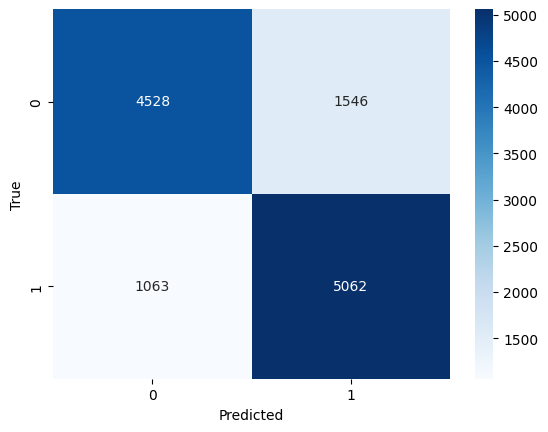

In [24]:
#Realizamos una predicción sobre el set de test
y_pred = knn_hyperparametros.predict(x_test)
#Valores Predichos
y_pred

metricas(y_pred, y_test)

In [25]:
knn_default=KNeighborsClassifier()
#Entreno el arbol en todo el set
model = knn_default.fit(x_train,y_train)

In [26]:
#Realizamos una predicción sobre el set de test
y_pred = knn_default.predict(x_test)
#Valores Predichos
y_pred

array([0, 0, 0, ..., 1, 0, 0])

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      6074
           1       0.74      0.74      0.74      6125

    accuracy                           0.74     12199
   macro avg       0.74      0.74      0.74     12199
weighted avg       0.74      0.74      0.74     12199



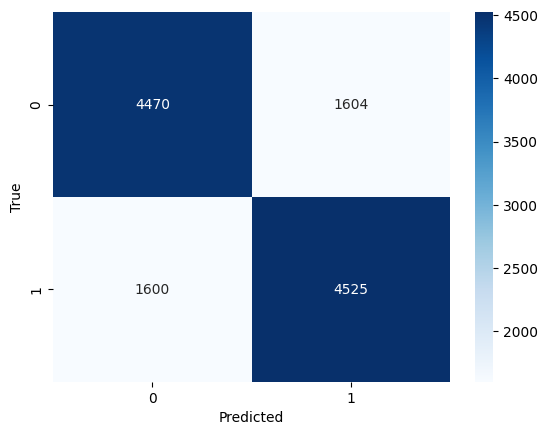

In [27]:
metricas(y_pred, y_test)

In [28]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7373555209443396
Recall: 0.7387755102040816
Precision: 0.7382933594387339
f1 score: 0.738534356128611


#### Submit


In [29]:
knn_hyperparametros_submit=KNeighborsClassifier().set_params(**params)
knn_default_submit=KNeighborsClassifier()

createSubmitOfModel(knn_hyperparametros_submit, 'knn_hyperparametros_submit')
createSubmitOfModel(knn_default_submit, 'knn_default_submit')

####Guardamos los modelos

In [63]:
modelos = {'knn_hyperparametros_submit': knn_hyperparametros_submit, 'knn_default_submit': knn_default_submit}

for name in modelos:
  joblib.dump(modelos[name], ruta_archivo + name)

### SVM

####Armamos el escalado de datos para las variables

In [30]:
#Armo una version escalada con minmax (media=0 , var=1  )
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train) 
x_test_minmax  = min_max_scaler.transform(x_test) 

#Armo una version estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      6074
           1       0.84      0.84      0.84      6125

    accuracy                           0.84     12199
   macro avg       0.84      0.84      0.84     12199
weighted avg       0.84      0.84      0.84     12199



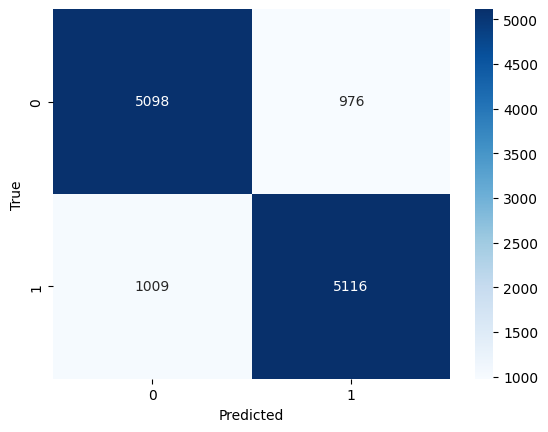

In [31]:
svm_norm_nombre = "svm_norm.joblib"

if os.path.isfile(ruta_archivo + svm_norm_nombre):
  svm_norm = joblib.load(ruta_archivo + svm_norm_nombre)

else:
  #Construyo un modelo SVM  
  svm_norm= SVC()

  #Lo entreno con los datos escalados con normalizacion
  svm_norm.fit(x_train_norm, y_train)

#Hago la prediccion y calculo las métricas
y_pred_norm=svm_norm.predict(x_test_norm)
metricas(y_pred_norm,y_test)

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      6074
           1       0.82      0.84      0.83      6125

    accuracy                           0.83     12199
   macro avg       0.83      0.83      0.83     12199
weighted avg       0.83      0.83      0.83     12199



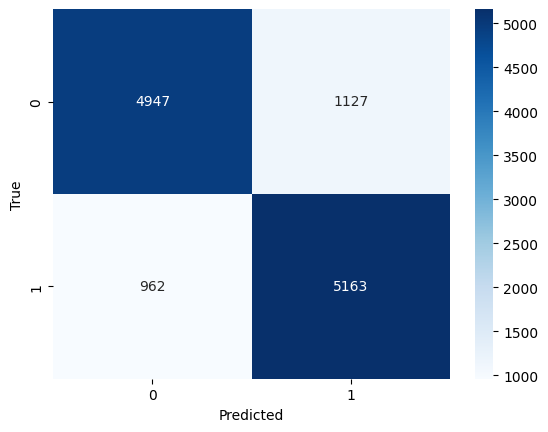

In [32]:
svm_minmax_nombre = "svm_minmax.joblib"

if os.path.isfile(ruta_archivo + svm_minmax_nombre):
  svm_minmax = joblib.load(ruta_archivo + svm_minmax_nombre)

else:
  #Construyo un modelo SVM
  svm_minmax= SVC()

  #Lo entreno con los datos escalados con min max
  svm_minmax.fit(x_train_minmax, y_train)

#Hago la prediccion y calculo las métricas
y_pred_minmax=svm_minmax.predict(x_test_minmax)
metricas(y_pred_minmax,y_test)

####Linear

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      6074
           1       0.80      0.80      0.80      6125

    accuracy                           0.80     12199
   macro avg       0.80      0.80      0.80     12199
weighted avg       0.80      0.80      0.80     12199



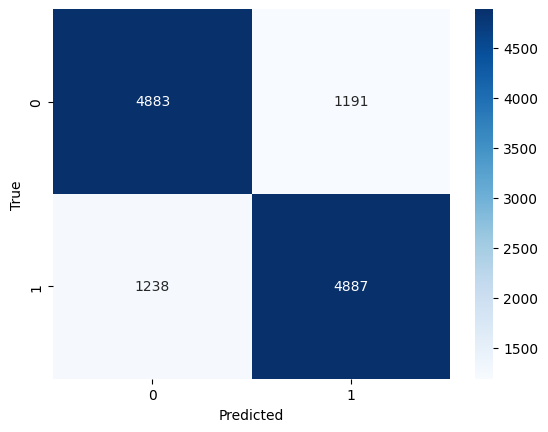

In [33]:
clf_kernel_lineal_nombre = "clf_kernel_lineal.joblib"

if os.path.isfile(ruta_archivo + clf_kernel_lineal_nombre):
  clf_lin = joblib.load(ruta_archivo + clf_kernel_lineal_nombre)

else:
  #Creo un clasificador con kernel lineal y lo entreno sobre los datos escalados min-max
  clf_lin = SVC(kernel='linear', C=5)
  clf_lin.fit(x_train_minmax, y_train)

#Hago la predicción y calculo las métricas
y_pred_lin=clf_lin.predict(x_test_minmax)
metricas(y_pred_lin,y_test)

####Polinomica

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      6074
           1       0.83      0.85      0.84      6125

    accuracy                           0.84     12199
   macro avg       0.84      0.84      0.84     12199
weighted avg       0.84      0.84      0.84     12199



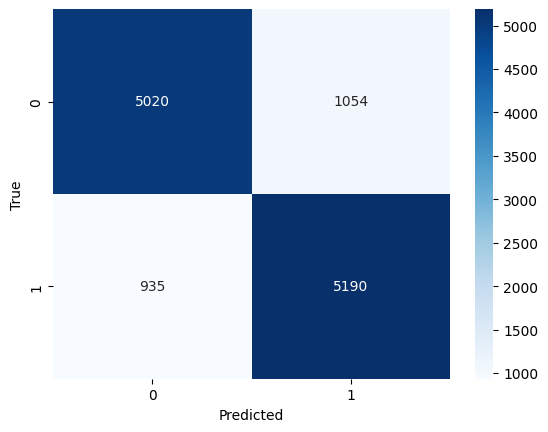

In [34]:
clf_kernel_polinomico_nombre = "clf_kernel_poly.joblib"

if os.path.isfile(ruta_archivo + clf_kernel_polinomico_nombre):
  clf_pol = joblib.load(ruta_archivo + clf_kernel_polinomico_nombre)

else:
  #Creo un clasificador con kernel polinomico y lo entreno sobre los datos escalados min-max
  clf_pol = SVC(kernel='poly', C=3)
  clf_pol.fit(x_train_minmax, y_train)

#Hago la predicción y calculo las métricas
y_pred_pol=clf_pol.predict(x_test_minmax)
metricas(y_pred_pol,y_test)

####Radial

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      6074
           1       0.83      0.85      0.84      6125

    accuracy                           0.84     12199
   macro avg       0.84      0.84      0.84     12199
weighted avg       0.84      0.84      0.84     12199



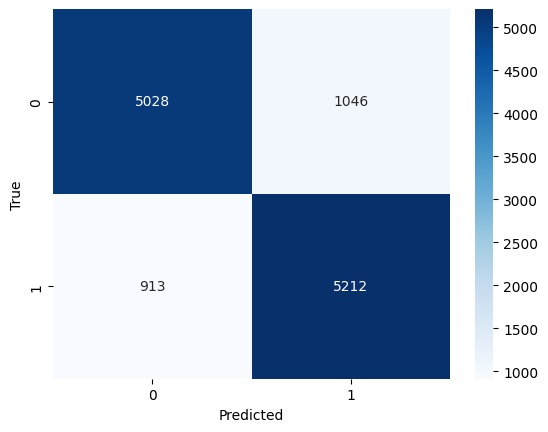

In [35]:
clf_kernel_radial_nombre = "clf_kernel_rbf.joblib"

if os.path.isfile(ruta_archivo + clf_kernel_radial_nombre):
  clf_rad = joblib.load(ruta_archivo + clf_kernel_radial_nombre)

else:
  #Creo un clasificador con kernel radial y lo entreno sobre los datos escalados min-max
  clf_rad = SVC(kernel='rbf', C=5)
  clf_rad.fit(x_train_minmax, y_train)

#Hago la predicción y calculo las métricas
y_pred_rad=clf_rad.predict(x_test_minmax)
metricas(y_pred_rad,y_test)

#### Submit


In [36]:
SVMSubmitLinear = SVC(kernel='linear', C=5)
SVMSubmitPolynomial = SVC(kernel='poly', C=3)
SVMSubmitRadial = SVC(kernel='rbf', C=5)

createSubmitOfModel(SVMSubmitLinear, 'SVMSubmitLinear')
createSubmitOfModel(SVMSubmitPolynomial, 'SVMSubmitPolynomial')
createSubmitOfModel(SVMSubmitRadial, 'SVMSubmitRadial')

####Guardamos los modelos

In [37]:
modelos = {svm_norm_nombre: svm_norm, svm_minmax_nombre: svm_minmax, clf_kernel_lineal_nombre: SVMSubmitLinear, clf_kernel_polinomico_nombre: SVMSubmitPolynomial, clf_kernel_radial_nombre: SVMSubmitRadial}

for name in modelos:
  joblib.dump(modelos[name], ruta_archivo + name)

### Random Forest

In [38]:
rfDefault = RandomForestClassifier()
rfDefault.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [39]:
#Entrenamos el modelo
rfDefaultModel = rfDefault.fit(X = x_train, y = y_train)

In [40]:
#Realizamos una predicción sobre el set de test
y_pred = rfDefaultModel.predict(x_test)


              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6074
           1       0.89      0.87      0.88      6125

    accuracy                           0.88     12199
   macro avg       0.88      0.88      0.88     12199
weighted avg       0.88      0.88      0.88     12199



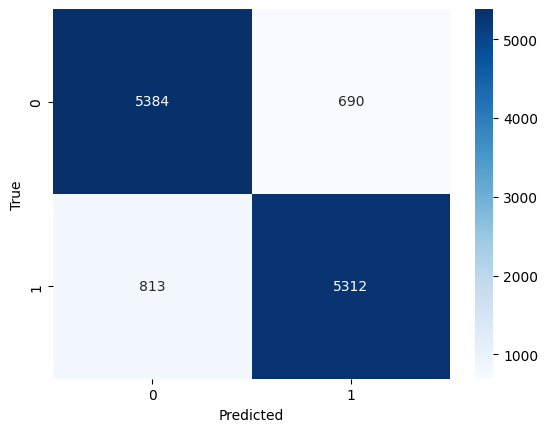

In [41]:
metricas(y_pred, y_test)

In [42]:
x_train.shape

(48794, 67)

In [43]:
# attrs: sqrt(NumCols), semilla, Todos los cpu
rfCV = RandomForestClassifier(max_features='sqrt', random_state=1, n_jobs=-1)

paramsGrid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [3, 5, 20], 
               "min_samples_split" : [6, 10, 40], 
               "n_estimators": [50, 100, 150] }

#Probamos entrenando sólo con 1 métrica
randomSearch = RandomizedSearchCV(estimator=rfCV, param_distributions=paramsGrid, scoring="f1", cv=8, n_iter=15, n_jobs=-1)
randomSearchFit = randomSearch.fit(X = x_train, y = y_train)

In [44]:
randomSearchFit.best_params_

{'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'criterion': 'gini'}

Algunos resultados: <br>
con n_iter=10 y cv=5 {<br>

```
  {'n_estimators': 100,
  'min_samples_split': 10,
  'min_samples_leaf': 5,
  'criterion': 'entropy'}
```
  f1: 8571520074093613 <br>
con n_iter=15 y cv=8 {<br>
```
  {'n_estimators': 100,
  'min_samples_split': 6,
  'min_samples_leaf': 3,
  'criterion': 'entropy'}<br>
```
  f1: 8648822979373962<br>
}

In [45]:
print("f1 score en entrenamiento con cross validation: "+str(randomSearchFit.best_score_))

f1 score en entrenamiento con cross validation: 0.8726261791665771


In [46]:
#Obtenemos el mejor modelo
bestRFwithCV=randomSearchFit.best_estimator_

#Predicción
yPredByBestRFwithCV = bestRFwithCV.predict(x_test)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6074
           1       0.88      0.86      0.87      6125

    accuracy                           0.87     12199
   macro avg       0.87      0.87      0.87     12199
weighted avg       0.87      0.87      0.87     12199



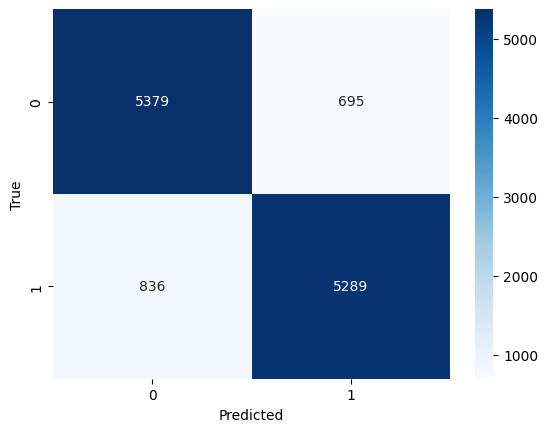

In [47]:
metricas(yPredByBestRFwithCV, y_test)

#### Submit

In [48]:
cvParams = {'max_features':'sqrt', 'random_state':1, 'n_jobs':-1,'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'entropy'}
RFSubmitWithCV = RandomForestClassifier(**cvParams)
RFSubmitDefault = RandomForestClassifier()

createSubmitOfModel(RFSubmitDefault, 'RFSubmitDefault')
createSubmitOfModel(RFSubmitWithCV, 'RFSubmitWithCV')

#### Guardo modelos

In [64]:
####Guardamos los modelos

modelos = {'RFSubmitDefault': RFSubmitDefault, 'RFSubmitWithCV': RFSubmitWithCV}

for name in modelos:
  joblib.dump(modelos[name], ruta_archivo + name)

### Ensambles Híbridos

#### Voting

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6074
           1       0.88      0.88      0.88      6125

    accuracy                           0.88     12199
   macro avg       0.88      0.88      0.88     12199
weighted avg       0.88      0.88      0.88     12199



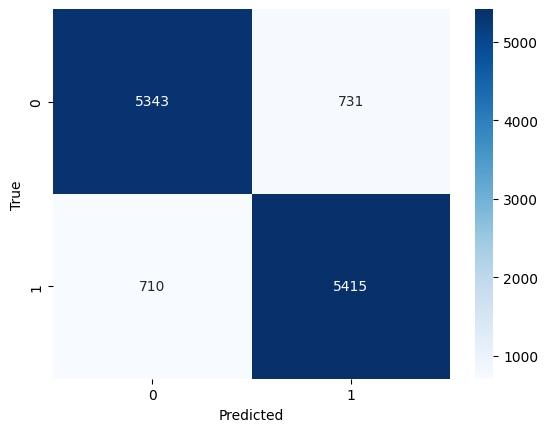

In [51]:
ensamble_voting_soft_nombre= "ensamble_voting_soft.joblib"

if os.path.isfile(ruta_archivo + ensamble_voting_soft_nombre):
  votingClasifSoftModel = joblib.load(ruta_archivo + ensamble_voting_soft_nombre)

else:  
  knnParams = {'weights': 'distance', 'p': 1, 'n_neighbors': 30, 'leaf_size': 10, 'algorithm': 'kd_tree'}
  #Modelos Base
  base_models = [('RF', RandomForestClassifier()),
                ('xgboost', xgb.XGBClassifier()),
                ('knn', KNeighborsClassifier().set_params(**knnParams))]

  #Ensamble híbrido tipo Voting
  votingClasifSoftModel = VotingClassifier(estimators = base_models, voting = 'soft')

  #Entreno el ensemble
  votingClasifSoftModel.fit(x_train, y_train)

#Evaluo en conjunto de test
yPredVoting = votingClasifSoftModel.predict(x_test)
metricas(yPredVoting, y_test)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6074
           1       0.88      0.88      0.88      6125

    accuracy                           0.88     12199
   macro avg       0.88      0.88      0.88     12199
weighted avg       0.88      0.88      0.88     12199



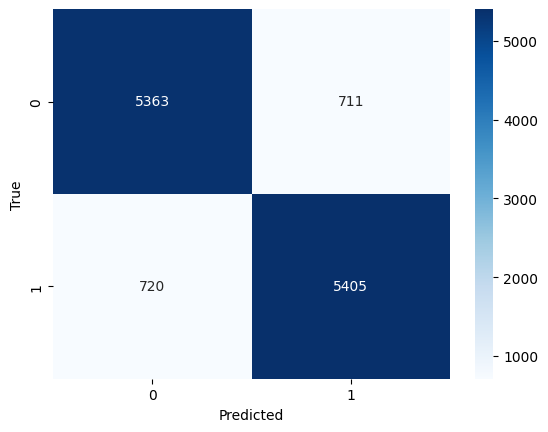

In [52]:
ensamble_voting_hard_nombre= "ensamble_voting_hard.joblib"

if os.path.isfile(ruta_archivo + ensamble_voting_hard_nombre):
  votingClasifHardModel = joblib.load(ruta_archivo + ensamble_voting_hard_nombre)

else:   
  knnParams = {'weights': 'distance', 'p': 1, 'n_neighbors': 30, 'leaf_size': 10, 'algorithm': 'kd_tree'}
  #Modelos Base
  base_models = [('RF', RandomForestClassifier()),
                ('xgboost', xgb.XGBClassifier()),
                ('knn', KNeighborsClassifier().set_params(**knnParams))]

  #Ensamble híbrido tipo Voting
  votingClasifHardModel = VotingClassifier(estimators = base_models, voting = 'hard', n_jobs=-1)

  #Entreno el ensemble
  votingClasifHardModel.fit(x_train, y_train)

#Evaluo en conjunto de test
yPredVoting = votingClasifHardModel.predict(x_test)
metricas(yPredVoting, y_test)

submit

In [53]:
knnParams = {'weights': 'distance', 'p': 1, 'n_neighbors': 30, 'leaf_size': 10, 'algorithm': 'kd_tree'}
#Modelos Base
base_models = [('RF', RandomForestClassifier()),
              ('xgboost', xgb.XGBClassifier()),
              ('knn', KNeighborsClassifier().set_params(**knnParams))]

#Ensamble híbrido tipo Voting
votingClasifSoft = VotingClassifier(estimators = base_models, voting = 'soft', n_jobs=-1)
votingClasifHard = VotingClassifier(estimators = base_models, voting = 'hard', n_jobs=-1)

createSubmitOfModel(votingClasifSoft, 'votingClasifSoft')
createSubmitOfModel(votingClasifHard, 'votingClasifHard')


#### Stacking

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      6074
           1       0.89      0.88      0.88      6125

    accuracy                           0.88     12199
   macro avg       0.88      0.88      0.88     12199
weighted avg       0.88      0.88      0.88     12199



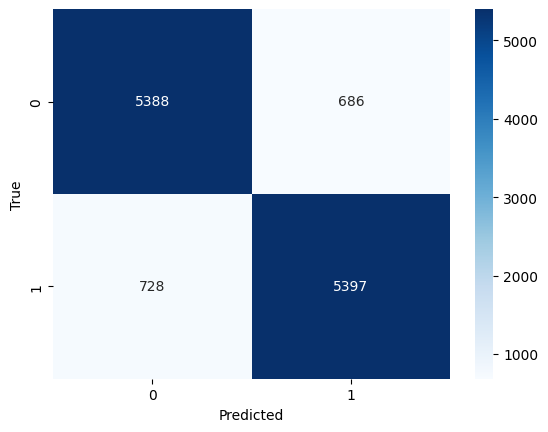

In [54]:
ensamble_stacking_nombre= "ensamble_stacking.joblib"

if os.path.isfile(ruta_archivo + ensamble_stacking_nombre):
  stacking_model = joblib.load(ruta_archivo + ensamble_stacking_nombre)

else:  
  knnParams = {'weights': 'distance', 'p': 1, 'n_neighbors': 30, 'leaf_size': 10, 'algorithm': 'kd_tree'}
  #Modelos Base
  base_models = [('RF', RandomForestClassifier()),
                ('xgboost', xgb.XGBClassifier()),
                ('knn', KNeighborsClassifier().set_params(**knnParams))]

  #Meta Modelo
  # meta_model = LogisticRegressionCV()

  #Ensemble Stacking con final estimator default (LinearRegressionModel)
  stacking_model = StackingClassifier(estimators=base_models, 
                                      #passthrough=True, esto tira error:  sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
                                      # final_estimator=meta_model, 
                                      # cv=5,
                                      #verbose=2,
                                      n_jobs=-1)

  stacking_model.fit(x_train,y_train)


yPredStacking= stacking_model.predict(x_test)

#Evaluo en conjunto de test
metricas(yPredStacking, y_test)

Submit

In [55]:
knnParams = {'weights': 'distance', 'p': 1, 'n_neighbors': 30, 'leaf_size': 10, 'algorithm': 'kd_tree'}
#Modelos Base
base_models = [('RF', RandomForestClassifier()),
              ('xgboost', xgb.XGBClassifier()),
              ('knn', KNeighborsClassifier().set_params(**knnParams))]


#Ensemble Stacking con final estimator default (LinearRegressionModel)
stacking_modelSubmit = StackingClassifier(estimators=base_models, 
                                    #passthrough=True, esto tira error:  sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1)
                                    #verbose=2,
                                    n_jobs=-1)

createSubmitOfModel(stacking_modelSubmit, 'stacking_modelSubmit')

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


####Guardamos los modelos

In [56]:
modelos = {ensamble_voting_soft_nombre: votingClasifSoft, ensamble_voting_hard_nombre: votingClasifHard, ensamble_stacking_nombre: stacking_modelSubmit}

for name in modelos:
  joblib.dump(modelos[name], ruta_archivo + name)

### XGBoost

Utilizamos los parametros por default del modelo de XGBoost ya que intentamos optimizar los parámetros con cross validation pero tardaba mucho en entrenar ese modelo. Además, las métricas con los valores por default dieron muy bien y el modelo hasta el momento es el que más rápido se entreno superando ampliamente en tiempos a los demás.

Valores default:

* `max_depth`: 6
* `learning_rate`: 0.3
* `n_estimators`: 100

In [57]:
xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5985
           1       0.88      0.87      0.87      6214

    accuracy                           0.87     12199
   macro avg       0.87      0.87      0.87     12199
weighted avg       0.87      0.87      0.87     12199



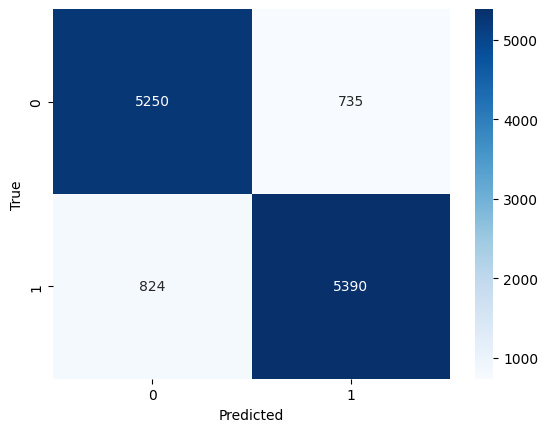

In [58]:
#Evaluo en el set de test
y_pred_proba= xgb_model.predict_proba(x_test)

#Matriz de Confusion
y_pred=xgb_model.predict(x_test)

metricas(y_test, y_pred)

Ahora utilizamos el método que nos provee xgb para cross validation y buscar los mejores hyperparámetros cambiando el learning rate y el max depth.

* Algunas métricas comunes incluyen 'rmse' (Root Mean Squared Error), 'mae' (Mean Absolute Error), 'logloss' (Logarithmic Loss), 'error' (Error de clasificación) y 'auc' (Area Under the ROC Curve). Puedes especificar múltiples métricas separadas por coma.

In [59]:
data_dmatrix = xgb.DMatrix(data=x_train, label=y_train)

params = {
    'max_depth': 3,
    'learning_rate':0.1,
}

#Entreno CV para probar el learning rate
results=xgb.cv(dtrain=data_dmatrix,nfold=5, params = params,num_boost_round=8,metrics=['auc', 'error'])
results

,train-auc-mean,train-auc-std,train-error-mean,train-error-std,test-auc-mean,test-auc-std,test-error-mean,test-error-std
0,0.780790,0.000952,0.276002,0.001236,0.779807,0.003936,0.276735,0.006023
1,0.854328,0.000900,0.216010,0.000913,0.853810,0.002985,0.216768,0.003417
2,0.859033,0.005812,0.261174,0.014820,0.857877,0.005739,0.264438,0.016384
3,0.856089,0.001255,0.214309,0.001046,0.855921,0.003145,0.214801,0.003685
4,0.867601,0.005284,0.221200,0.013642,0.866534,0.004812,0.222179,0.014918
5,0.873470,0.005765,0.209841,0.008467,0.872139,0.007846,0.211235,0.011305
6,0.876800,0.004019,0.209631,0.010253,0.875883,0.002753,0.211050,0.013194
7,0.880978,0.003250,0.203780,0.005911,0.880084,0.002200,0.205701,0.012102


Como los valores no cambiaron mucho en relación a los valores por default, utilizamos la predicción del modelo entrenado por default.

Por otro lado, hicimos pruebas utilizando el método de sklearn pero este nos tardaba mucho tiempo en entrenar y decidimos quitarlo de la notebook (más de 1 hora y media)

In [60]:
xgb_model_kaggel = xgb.XGBClassifier(random_state=0, n_estimators=100)

createSubmitOfModel(xgb_model_kaggel, 'xgb_model')

In [61]:
joblib.dump(xgb_model, ruta_archivo + "xgb_model.joblib")

['/content/drive/MyDrive/TP1/CH3/modelos/xgb_model.joblib']